In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [260]:
%matplotlib inline
np.set_printoptions(precision=4)

### Carga dos dados

In [261]:
df_seg = pd.read_json('./datasets/extracao-segmentos-atos.json')

### Estrutura da fonte de dados

In [262]:
df_seg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206488 entries, 0 to 206487
Data columns (total 6 columns):
id_ato      206488 non-null int64
data_pub    206488 non-null object
tipo_ato    206488 non-null object
id_seg      206488 non-null int64
tipo_seg    206488 non-null object
txt_seg     206488 non-null object
dtypes: int64(2), object(4)
memory usage: 9.5+ MB


#### Notas:
* 206.488 observações (segmentos)
* Nenhum valor ausente
* txt_seg contém o texto dos segmentos a serem analisados
* tipo_seg a variável alvo (labels)

In [263]:
# Conversão do atributo data_pub para formato de data
df_seg['data_pub'] = pd.to_datetime(df_seg['data_pub'])

### Análise da quantidade de atos por tipo de ato

In [264]:
qtd_ato_por_tipo = df_seg[['tipo_ato', 'id_ato']].groupby('tipo_ato')['id_ato'].nunique()
df_qtd_ato_por_tipo = pd.DataFrame(qtd_ato_por_tipo)
df_qtd_ato_por_tipo.columns = ['qtd_ato']
df_qtd_ato_por_tipo.reset_index(inplace=True)
df_qtd_ato_por_tipo.sort_values(by='qtd_ato', ascending=False, inplace=True)

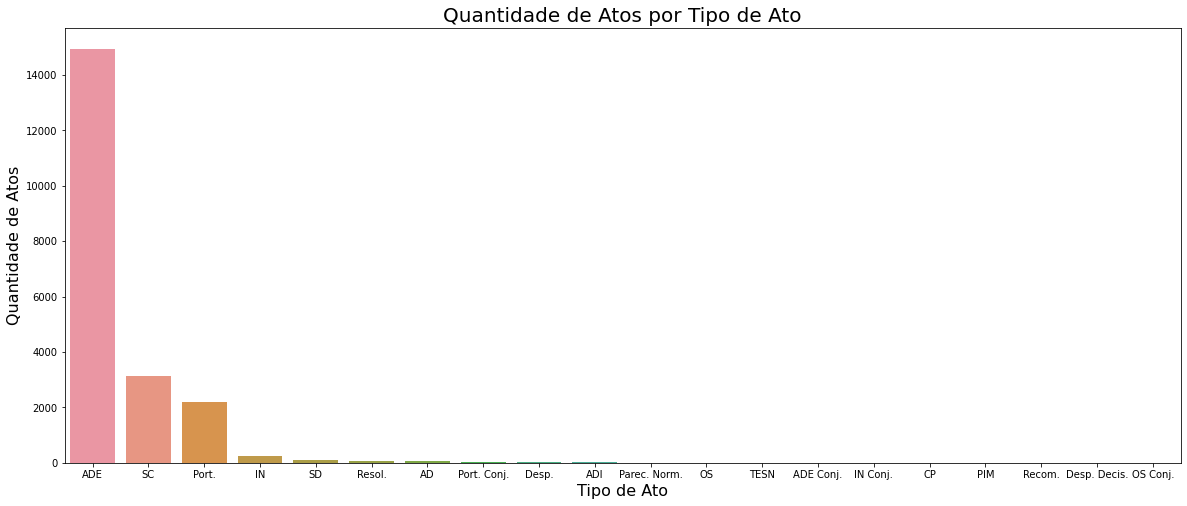

In [265]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='tipo_ato', y='qtd_ato', data=df_qtd_ato_por_tipo)
ax.set_title('Quantidade de Atos por Tipo de Ato', fontsize=20)
ax.set_ylabel('Quantidade de Atos', fontsize=16)
ax.set_xlabel('Tipo de Ato', fontsize=16)
plt.show()

In [266]:
qtd_ato_ade = df_qtd_ato_por_tipo[df_qtd_ato_por_tipo['tipo_ato'] == 'ADE']['qtd_ato'].iloc[0]
qtd_total_ato = df_qtd_ato_por_tipo['qtd_ato'].sum()
perc_ato_ade = qtd_ato_ade/qtd_total_ato
print('Quantidade de atos do tipo ADE: {:5d}'.format(qtd_ato_ade))
print('Quantidade total de atos: {:5d}'.format(qtd_total_ato))
print('Percentual de atos do tipo ADE: {:5.2f}%'.format(perc_ato_ade*100))

Quantidade de atos do tipo ADE: 14948
Quantidade total de atos: 20821
Percentual de atos do tipo ADE: 71.79%


#### Notas:
* Atos do tipo ADE representam mais 71.79% do total de atos 

### Análise da quantidade de segmentos por tipo de segmento

In [267]:
qtd_seg_tipo = df_seg[['id_seg', 'tipo_seg']].groupby('tipo_seg').count().sort_values("id_seg", ascending=False)
qtd_seg_tipo.columns = ['qtd_seg']
qtd_seg_tipo.reset_index(inplace=True)

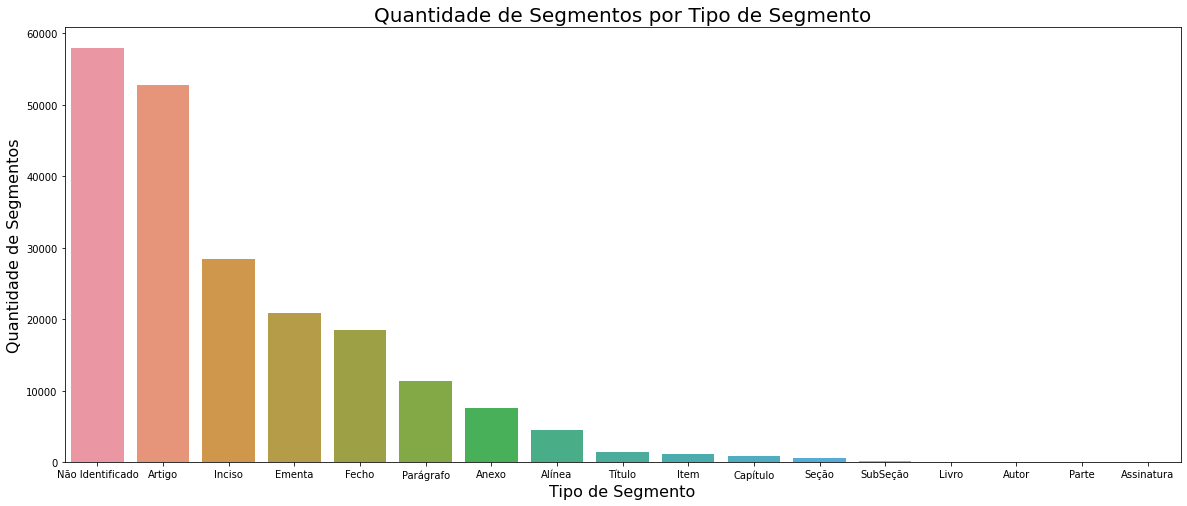

In [268]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg', data=qtd_seg_tipo)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

In [269]:
qtd_seg_tipo

,tipo_seg,qtd_seg
0,Não Identificado,57941
1,Artigo,52808
2,Inciso,28479
3,Ementa,20824
4,Fecho,18571
5,Parágrafo,11404
6,Anexo,7549
7,Alínea,4475
8,Título,1424
9,Item,1218


#### Notas:
* 17 classes
* Segmentos não identificados são maioria
* Investigar hipóteses:
  * Omissão da classificação manual (segmento deveria ser de outra classe)?
  * A classe está sendo usada para alguma situação específica?

## Análise considerando somente os atos do tipo ADE

In [270]:
df_seg_ade = pd.read_json('./datasets/extracao-segmentos-atos-ade.json')

In [271]:
df_seg_ade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115040 entries, 0 to 115039
Data columns (total 6 columns):
id_ato      115040 non-null int64
data_pub    115040 non-null object
tipo_ato    115040 non-null object
id_seg      115040 non-null int64
tipo_seg    115040 non-null object
txt_seg     115040 non-null object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


In [272]:
df_seg_ade['data_pub'] = pd.to_datetime(df_seg_ade['data_pub'])

#### Notas:
* Redução do número de observações de 206.488 para 115.040

In [273]:
qtd_seg_tipo_ade = df_seg_ade[['id_seg', 'tipo_seg']].groupby('tipo_seg').count().sort_values("id_seg", ascending=False)
qtd_seg_tipo_ade.columns = ['qtd_seg']
qtd_seg_tipo_ade.reset_index(inplace=True)

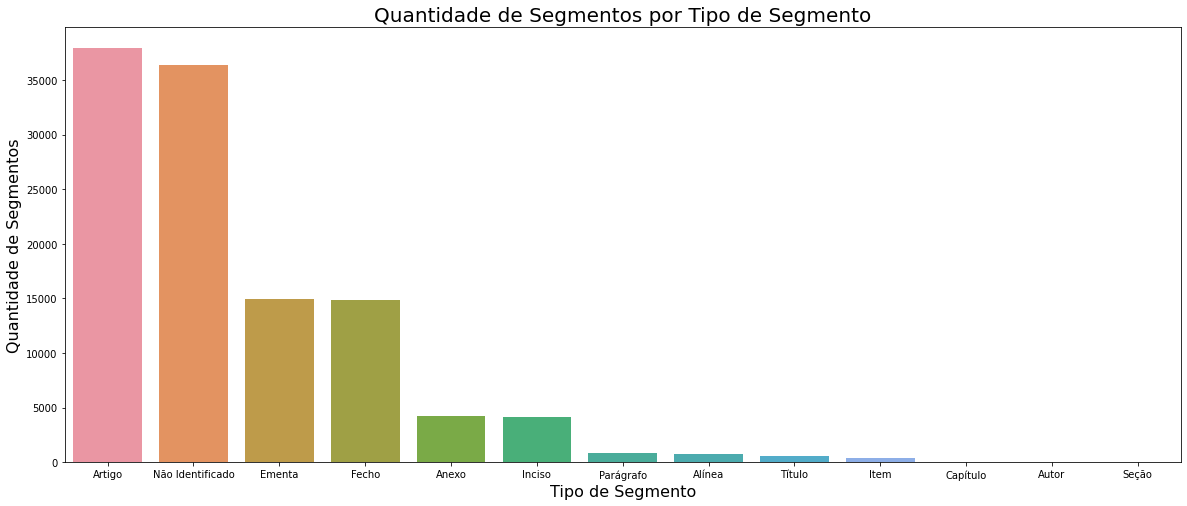

In [274]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg', data=qtd_seg_tipo_ade)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

In [275]:
qtd_seg_tipo_ade

,tipo_seg,qtd_seg
0,Artigo,37922
1,Não Identificado,36343
2,Ementa,14948
3,Fecho,14866
4,Anexo,4232
5,Inciso,4134
6,Parágrafo,861
7,Alínea,780
8,Título,545
9,Item,398


### Comparando os resultados com todos os tipos de ato e somente com atos ADE

In [276]:
df_seg_cons = qtd_seg_tipo.merge(qtd_seg_tipo_ade, how='left', on='tipo_seg')
df_seg_cons.columns = ['tipo_seg', 'qtd_seg', 'qtd_seg_ade']

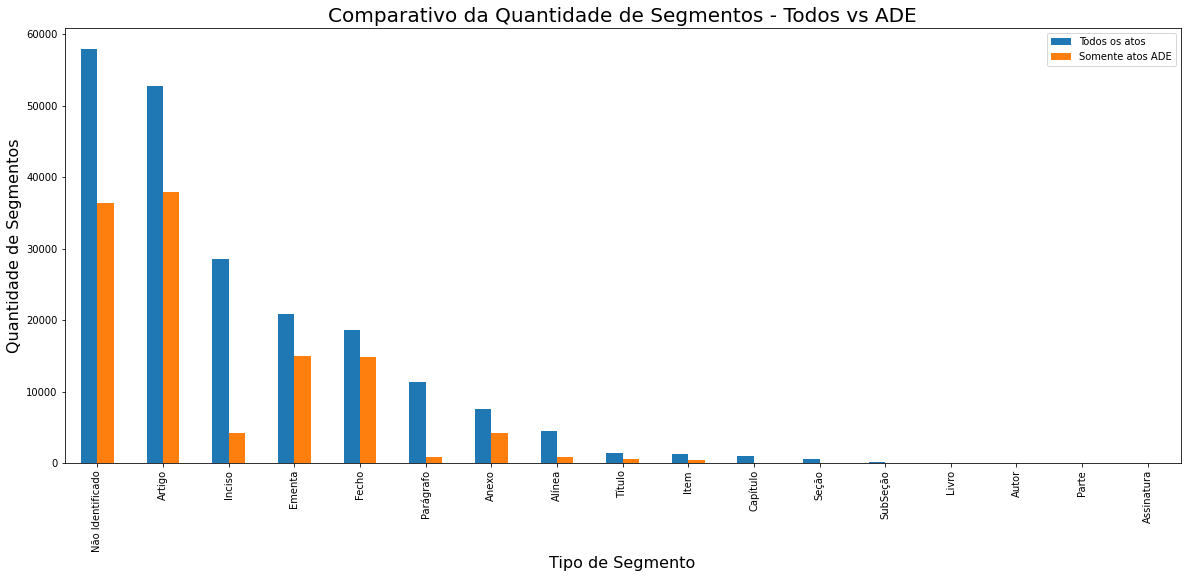

In [277]:
ax = df_seg_cons.plot(kind='bar', x='tipo_seg', figsize=(20,8))
ax.set_title('Comparativo da Quantidade de Segmentos - Todos vs ADE', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
ax.legend(['Todos os atos', 'Somente atos ADE'])
plt.show()

In [278]:
df_seg_cons

,tipo_seg,qtd_seg,qtd_seg_ade
0,Não Identificado,57941,36343.0
1,Artigo,52808,37922.0
2,Inciso,28479,4134.0
3,Ementa,20824,14948.0
4,Fecho,18571,14866.0
5,Parágrafo,11404,861.0
6,Anexo,7549,4232.0
7,Alínea,4475,780.0
8,Título,1424,545.0
9,Item,1218,398.0


#### Notas:
* Segmentos não identificados deixaram de ser majoritários mas ainda carecem de uma avaliação mais detalhada
* As categorias Assinatura, Parte, Livro e Subseção não possuem segmento para atos ADE
* As categorias Parágrafo, Alínea, Título, Item, Capítuo, Autor e Seção ficaram com representatividade baixa (verificar percentual)

### Excluindo classes com pouca (<1%) ou nenhuma representatividade (NaN) em atos ADE

In [279]:
# Nenhuma representatividade
df_seg_cons.dropna(inplace=True)
df_seg_cons['qtd_seg_ade'] = df_seg_cons['qtd_seg_ade'].astype('int')

In [280]:
total_seg_ade = df_seg_cons['qtd_seg_ade'].sum()
df_seg_cons['perc_seg_ade'] = df_seg_cons['qtd_seg_ade']/total_seg_ade

In [281]:
# Pouca representatividade
df_seg_cons = df_seg_cons[df_seg_cons['perc_seg_ade']>=0.01]

In [284]:
df_seg_cons.sort_values("qtd_seg_ade", ascending=False, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


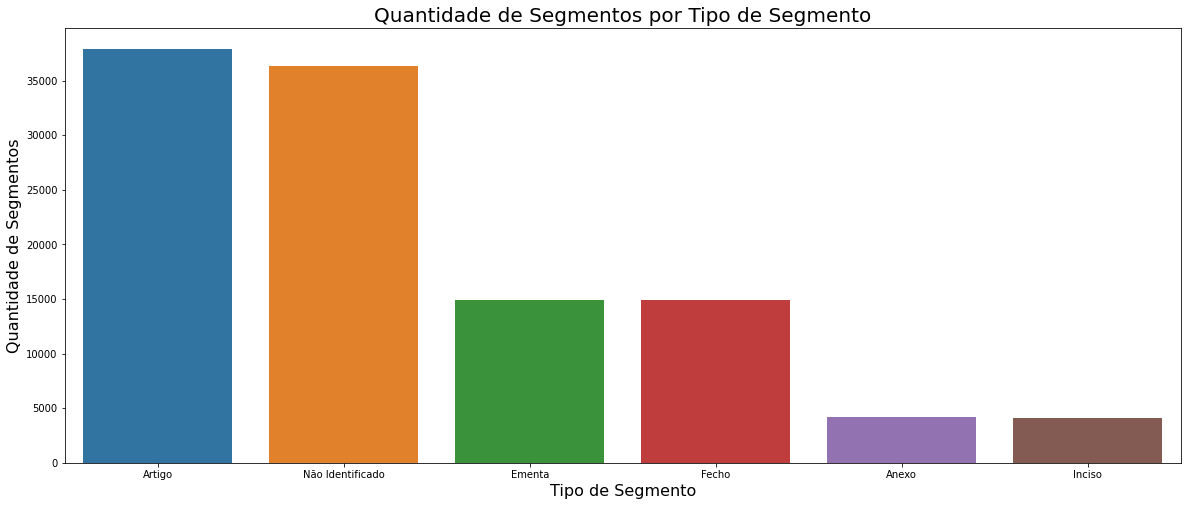

In [285]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg_ade', data=df_seg_cons)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

## Conclusões
* A redução do escopo de dados para os atos do tipo ADE permitiu a diminuição do número de classes de segmentos a serem consideradas no treinamento do modelo de classificação, com perdas mínimas para o modelo (porque foram removidas somente classes com nenhuma representatividade ou representatividade abaixo de 1%).
* O escopo de dados permanece significativo já que os atos ADE representam 71.79% do total de atos.
* A situação dos segmentos não identificados carece de investigação mais aprofundada. 
